In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from warnings import filterwarnings

filterwarnings("ignore", category=UserWarning)

In [2]:
SEQ_LEN = 60  # длина входного окна (дней)
HORIZON = 30  # сколько дней предсказываем сразу
HIDDEN = 128
EPOCHS = 120
BATCH = 64
LR = 1e-3
PATIENCE = 12
TEACH_RATE = 0.0
RET_CLIP = 0.10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
df = yf.download(
    "BTC-USD",
    start="2010-01-01",
    end=pd.Timestamp.now().strftime("%Y-%m-%d"),
    progress=False
)
df["log_ret"] = np.log(df["Close"]).diff()
df = df.dropna()

series = df["log_ret"].values.astype("float32").reshape(-1, 1)


def make_dataset(arr, seq_len, horizon):
    X, y = [], []
    for i in range(len(arr) - seq_len - horizon + 1):
        X.append(arr[i:i + seq_len])
        y.append(arr[i + seq_len:i + seq_len + horizon])
    return np.array(X), np.array(y)


X, y = make_dataset(series, SEQ_LEN, HORIZON)
split = int(len(X) * 0.8)

# обучаем скейлер только на train+warmup
scaler = StandardScaler().fit(series[: split + SEQ_LEN])
series_sc = scaler.transform(series)

X_sc, y_sc = make_dataset(series_sc, SEQ_LEN, HORIZON)
X_train, y_train = X_sc[:split], y_sc[:split]
X_val, y_val = X_sc[split:], y_sc[split:]

YF.download() has changed argument auto_adjust default to True


In [4]:
class SeqDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


train_loader = DataLoader(SeqDataset(X_train, y_train),
                          batch_size=BATCH, shuffle=True)
val_loader = DataLoader(SeqDataset(X_val, y_val),
                        batch_size=BATCH, shuffle=False)

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, kind="lstm", hidden=128, horizon=30):
        super().__init__()
        rnn = {"rnn": nn.RNN, "lstm": nn.LSTM, "gru": nn.GRU}[kind]
        self.is_lstm = (kind == "lstm")
        self.enc = rnn(1, hidden, batch_first=True)
        self.dec = rnn(1, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
        self.horizon = horizon

    def forward(self, x, teacher_y=None, teach_rate=0.0):
        B = x.size(0)
        _, hidden = self.enc(x)
        if self.is_lstm:
            h, c = hidden
            hidden = (h.contiguous(), c.contiguous())
        else:
            hidden = hidden.contiguous()

        inp = x[:, -1:]
        outs = []
        for t in range(self.horizon):
            out, hidden = self.dec(inp, hidden)
            y = self.fc(out)
            outs.append(y)
            inp = (teacher_y[:, t:t + 1] if teacher_y is not None
                                            and np.random.rand() < teach_rate else y)
        return torch.cat(outs, dim=1)

In [8]:
def train_model(kind):
    model = Seq2Seq(kind, hidden=HIDDEN, horizon=HORIZON).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    best_val, patience = np.inf, PATIENCE
    writer = SummaryWriter(f"runs/{kind}_{datetime.datetime.utcnow():%Y%m%d-%H%M%S}")

    for epoch in range(1, EPOCHS + 1):
        # training
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb, yb, teach_rate=TEACH_RATE)
            loss = nn.functional.mse_loss(pred, yb)  # MSE вместо L1
            loss.backward()
            opt.step()
            train_losses.append(loss.item())
        train_loss = np.mean(train_losses)

        # validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb)  # без teacher forcing
                val_losses.append(nn.functional.mse_loss(pred, yb).item())
        val_loss = np.mean(val_losses)

        writer.add_scalars("loss", {"train": train_loss, "val": val_loss}, epoch)
        print(f"{kind.upper():4} | epoch {epoch:3} | train {train_loss:.6f} | val {val_loss:.6f}")

        # early stopping
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = model.state_dict()
            patience = PATIENCE
        else:
            patience -= 1
            if patience == 0:
                print("    early stop")
                break

    writer.close()
    model.load_state_dict(best_state)
    return model, best_val

In [9]:
# обучение
models = {}
for kind in ("rnn", "lstm", "gru"):
    print(f"\nОбучаем {kind.upper()} …")
    net, val_mse = train_model(kind)
    print(f"{kind.upper()} готова, лучшая val MSE = {val_mse:.6f}\n")
    models[kind] = net


Обучаем RNN …
RNN  | epoch   1 | train 0.999318 | val 0.432068
RNN  | epoch   2 | train 0.998053 | val 0.432060
RNN  | epoch   3 | train 0.998579 | val 0.433117
RNN  | epoch   4 | train 0.997637 | val 0.432132
RNN  | epoch   5 | train 0.999619 | val 0.432132
RNN  | epoch   6 | train 0.997146 | val 0.433643
RNN  | epoch   7 | train 0.997304 | val 0.432343
RNN  | epoch   8 | train 0.997843 | val 0.432244
RNN  | epoch   9 | train 0.998301 | val 0.431988
RNN  | epoch  10 | train 0.997700 | val 0.431986
RNN  | epoch  11 | train 0.996433 | val 0.432141
RNN  | epoch  12 | train 0.997786 | val 0.432443
RNN  | epoch  13 | train 0.997528 | val 0.432055
RNN  | epoch  14 | train 0.997564 | val 0.431518
RNN  | epoch  15 | train 0.996179 | val 0.431892
RNN  | epoch  16 | train 0.997627 | val 0.432597
RNN  | epoch  17 | train 0.998112 | val 0.432357
RNN  | epoch  18 | train 0.998837 | val 0.432228
RNN  | epoch  19 | train 0.997843 | val 0.432317
RNN  | epoch  20 | train 0.998141 | val 0.431997
RNN  

In [10]:
pred_dict = {}
# последние SEQ_LEN дней перед прогнозным окном
start = len(series_sc) - SEQ_LEN - HORIZON
seq_input = series_sc[start: start + SEQ_LEN]
last_seq = torch.from_numpy(seq_input.reshape(1, SEQ_LEN, 1)).to(DEVICE)

# последняя известная цена перед окном
last_price = df["Close"].iloc[-HORIZON - 1].item()

for kind, net in models.items():
    net.eval()
    with torch.no_grad():
        pred_sc = net(last_seq).squeeze(0).cpu().numpy()
    pred_sc = pred_sc.ravel()
    # обратно в оригинальный масштаб
    pred_ret = scaler.inverse_transform(pred_sc.reshape(-1, 1)).ravel()
    pred_ret = np.clip(pred_ret, -RET_CLIP, RET_CLIP)
    # строим ценовую кривую
    prices = np.empty(HORIZON)
    prices[0] = last_price * np.exp(pred_ret[0])
    for t in range(1, HORIZON):
        prices[t] = prices[t - 1] * np.exp(pred_ret[t])
    pred_dict[kind.upper()] = prices

for name, prices in pred_dict.items():
    print(f"{name} first prices:", prices[:5])

RNN first prices: [94073.46875    94345.7215005  94498.85910616 94741.28495893
 94924.66630705]
LSTM first prices: [94414.921875   94589.09510088 94742.00756486 94896.27405119
 95054.90948284]
GRU first prices: [94403.21875    94529.10309278 94620.49263275 94680.99663085
 94721.09882433]


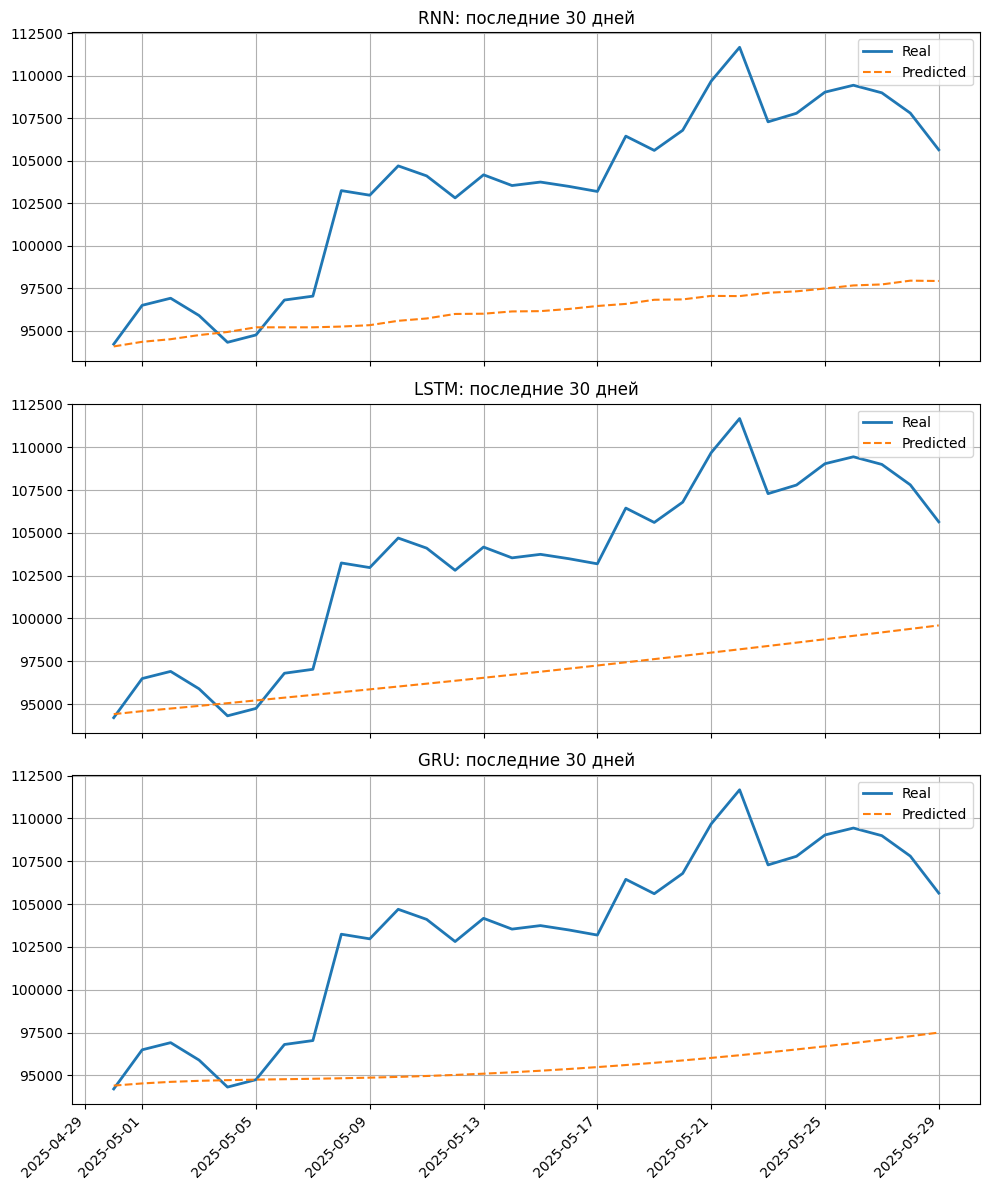

In [12]:
# визуализация
idx_tail = df.index[-HORIZON:]
real_tail = df["Close"].iloc[-HORIZON:].values

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
for ax, (name, pred) in zip(axs, pred_dict.items()):
    ax.plot(idx_tail, real_tail, label="Real", lw=2)
    ax.plot(idx_tail, pred, label="Predicted", ls="--")
    ax.set_title(f"{name}: последние {HORIZON} дней")
    ax.legend()
    ax.grid(True)

axs[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
# метрики
print("\nОшибка на последних 30 днях")
for name, pred in pred_dict.items():
    mae  = np.mean(np.abs(real_tail - pred))
    mape = np.mean(np.abs((real_tail - pred) / real_tail)) * 100
    print(f"{name:4} | MAE  {mae:9.2f} $ | MAPE {mape:7.2f} %")


Ошибка на последних 30 днях
RNN  | MAE    7577.38 $ | MAPE    7.15 %
LSTM | MAE    7166.94 $ | MAPE    6.77 %
GRU  | MAE    8006.64 $ | MAPE    7.55 %


# Выводы
1) Изначально прогноз цены действительно очень резко падал, спустя n часов раздумий было принято решение брать логарифмические доходности. Теперь график прогноза возрастает, что чуть больше похоже на правду. Это помогло, потому что, во-первых, это стабилизировало дисперсию, тк цены растут экспоненциально, а лог-доходности делают изменения аддитивными и более гауссовскими. Сама серия цен — нестационарная, а доходности (особенно логарифмические) обычно намного ближе к стационарному процессу, который RNN/LSTM/GRU проще моделировать.
Еще помогло сделать TEACH_RATE = 0, тк мы при обучении декодера вместо предсказания кормим истинное значение => ускоряется сходимость + у нас менее сильно накапливается ошибка
2) Судя по результатам, LSTM чуть лучше RNN и GRU, но всё равно не ловит волатильность.
3) Прогноз не совпадает с реальностью, тк:
- Копится ошибка. При авторегрессии любая небольшая неточность в прогнозе первого дня пойдет дальше, потому что это значение попадёт на вход для следующего шага.
- Высокая волатильность крипты
- Недостаточная сложность модели / horizon слишком велик
- Одна однаслойная RNN/LSTM/GRU с 128 скрытыми юнитами чаще хорошо прогнозирует на 1–5 шагов, но не на 30.
4) Идейно для более правильного прогноза надо: укоротить horizon (мб до 5–10 дней), добавить внешние факторы (объём, индикаторы, макро), и мб нужны более сложные архитектуры (Attention, Transformer).

